In [62]:
using Plots, Test

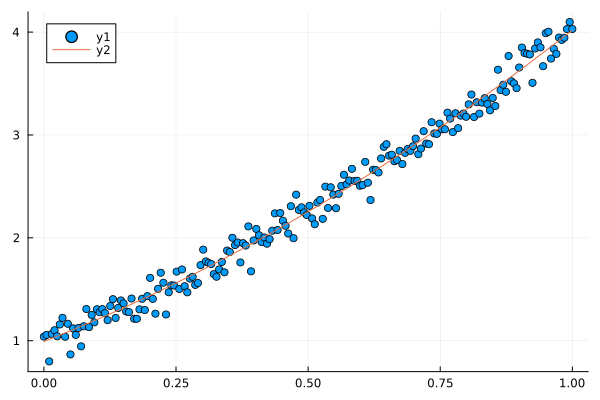

In [4]:
# Lets fit a quadratic function with random noise:

f = x -> x^2 + 2x + 1 + 0.1randn()

m = 200
x = range(0,1; length=m) # makes 1000 evenly spaced points between 0 and 1
𝐟 = f.(x)

# We want to find the polynomial p(x) = p_0 + p_1*x + p_2*x^2  so that
# p(x[k]) ≈ f(x[k])
# in the sense that norm([p(x[k]) - f(x[k]) for k = 1:m]) == norm(p.(x) -f.(x))
# Make the Vandermonde matrix

V = [x[k]^j for k=1:m, j=0:2]
# Then p.(x) == V*c for c = [p_0,p_1,p_2]
# Thus we want to minimise
# norm(V*c - 𝐟)
# i.e.

c = V \ 𝐟
p = x -> c[1] + c[2]x + c[3]x^2


scatter(x, 𝐟)
plot!(x, p.(x))

In [8]:
Q,R̂ = qr(V)
# Q is special type reprenting both Q̂ and Q. It acts on both ℝ^m and ℝ^n
Q*[1,2,3] ≈ Q*[1; 2; 3; zeros(m-3)]

true

In [9]:
# Q' behaves like U(m). Thus to get Q̂ we need to truncate:
R̂ \ (Q'𝐟)[1:3]

3-element Vector{Float64}:
 0.9925098089329052
 2.0190314052284424
 1.0089084076327104

In [10]:
# Alternatively:
Q̂ = Q[:,1:3]
R̂ \ Q̂'𝐟

3-element Vector{Float64}:
 0.992509808932904
 2.0190314052284433
 1.0089084076327093

## Householder

In [12]:
A = [1 2 3; 
     4 5 6;
     7 8 9; 
     10 11 12]
rank(A)

2

In [20]:
function householderreflection(x)
    T = float(eltype(x))
    y = Vector{T}(x)
    y[1] += norm(x)*sign(x[1])
    w = y/norm(y)
    I - 2w*w' # I represents identity matrix on any dimension
end

householderreflection (generic function with 1 method)

In [56]:
A = [1 2 3; 
     4 5 6;
     7 8 9; 
     10 11 13]

m,n = size(A)

𝐚₁ = A[:,1]
Q₁ = householderreflection(𝐚₁)
Q₁*𝐚₁ # first column made "sparse"

4-element Vector{Float64}:
 -12.884098726725126
   0.0
   8.881784197001252e-16
   8.881784197001252e-16

In [57]:
Q₁A = Q₁*A # first column made "sparse"
α₁, 𝐰₁ = Q₁A[1,1],Q₁A[1,:]

R₁ = Q₁ * R₁
A ≈ Q₁ * R₁ # partial-QR

true

In [58]:
A₂ = Q₁A[2:end,2:end]
𝐚₂ = A₂[:,1]
α₂, 𝐰₂ = R₂[1,1],R₂[1,:]
Q₂ = householderreflection(𝐚₂)

Q₂ * A₂

3×2 Matrix{Float64}:
 -1.04132      -1.77024
 -7.64634e-19  -0.546457
  3.84754e-17   0.0372184

In [59]:
Q̃₂ = Matrix(1.0I, m, m)
Q̃₂[2:end, 2:end] = Q₂

R₂ = Q̃₂*Q₁*A # first two columns made sparse

A ≈  Q₁*Q̃₂ * R₂ # partial-QR

true

In [78]:
A₃ = (Q₂ * A₂)[2:end,2:end]
𝐚₃ = A₃[:,1]

Q₃ = householderreflection(𝐚₃)
Q̃₃ = Matrix(1.0I, m, m)
Q̃₃[3:end, 3:end] = Q₃

R = Q̃₃ * Q̃₂*Q₁*A # first two columns made sparse

Q = Q₁*Q̃₂*Q̃₃

@test A ≈ Q*R
@test Q'Q ≈ I

Test Passed

In [79]:
Q₁ * Q̃₂ # Q₂ acts on just columns 2:n
Q = copy(Q₁)
Q[:,2:end] = Q[:,2:end] * Q₂
@test Q == Q₁ * Q̃₂

Q₁ * Q̃₂ *Q̃₃ # Q₃ acts on just columns 3:n
Q[:,3:end] = Q[:,3:end] * Q₃
@test Q ≈ Q₁ * Q̃₂ *Q̃₃

@test A ≈ Q*R

Test Passed

In [86]:
# algorithm
function householderqr(A)

    m,n = size(A)

    T = float(eltype(A))
    R = zeros(T, m, n)
    Q = Matrix{T}(I, m, m)

    Aⱼ = A


    for j = 1:n
        𝐚ⱼ = Aⱼ[:,1]
        Qⱼ = householderreflection(𝐚ⱼ)
        QⱼAⱼ = Qⱼ*Aⱼ # WARNING!!! O(n*m^2) operations! should be O(n*m)
        α,𝐰 = QⱼAⱼ[1,1],QⱼAⱼ[1,2:end]
        Aⱼ₊₁ = QⱼAⱼ[2:end,2:end]

        # populate R
        R[j,j] = α
        R[j,j+1:end] = 𝐰

        # update Q
        Q[:,j:end] = Q[:,j:end] * Qⱼ

        Aⱼ = Aⱼ₊₁
    end

    Q,R
    
end

4×3 Matrix{Float64}:
  1.0   2.0   3.0
  4.0   5.0   6.0
  7.0   8.0   9.0
 10.0  11.0  13.0